## Global Max SPEA with job bundling
- This is a variant of the SPEA algorithm in which the jobs are bundled together into 1 big circuit and sent to the backend.
- Note, the total API calls are bound by just **MAX_ITERS** as the job manager sends the circuits in a bundle and executes according to the backend limit on which we are executing

#### Trying out Job manager 
- This manager is used to **optimize** the api call time that is needed in the backend execution

In [ ]:
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit import IBMQ 
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education')

In [1]:
from qiskit import QuantumCircuit, execute, transpile, Aer 
from qiskit.extensions import UnitaryGate,Initialize
from qiskit.quantum_info import Statevector 
from qiskit.tools.visualization import plot_bloch_vector
from qiskit.tools.visualization import plot_histogram,plot_bloch_multivector  
import numpy as np 
from time import sleep 
import sys 
sys.path.append("..")
from scipy.stats import unitary_group 
import matplotlib.pyplot as plt 
%matplotlib inline 

- So what job manager does is that it takes all circuits, executes them in batches of 75 and brings back the results.
- This means, what I can do is I need (2Bm) jobs each consisting of resolution number of circuits.
- This means, I can bundle all the (2Bm.resolution) jobs together , get the result 
- Now, take first resolution number of jobs, get the max theta and cost and append to the list 
- At the end you will only have **max_iters** jobs that are sent to the backend instead of **max_iters.2*Bm** jobs, exponentially lesser api calls

In [2]:
from Modules.bundled_global_max_SPEA import bundled_changed_SPEA

### Testing
- This algorithm is tested for a phase gate of $ \theta = \frac{1}{9} $ 

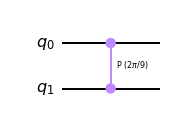

In [4]:
q = QuantumCircuit(2)
q.cp(2*np.pi*(1/9),0,1)
q.draw('mpl')

In [9]:
spe = bundled_changed_SPEA(q,resolution=20,error = 3,max_iters=10)

- Choosing backend as **ibmq_jakarta**

In [10]:
jakarta = provider.get_backend('ibmq_jakarta')

In [ ]:
thetas = []
for k in range(5):
    result = spe.get_eigen_pair(backend=jakarta,progress=True)
    print("Result is :",result)
    thetas.append(result['theta'])

Right : 0.40789473684210525
Left : 0
ITERATION NUMBER 1 ...
Transpiling circuits...
Transpilation Done!
Job sent...
Job has returned
100.000000 %completed
No change, updating a...

COST : 0.76953125
THETA : 0.15789473684210525
Right : 0.40789473684210525
Left : 0
ITERATION NUMBER 2 ...
Transpiling circuits...
Transpilation Done!
Job sent...
Job has returned
100.000000 %completed
No change, updating a...

COST : 0.76953125
THETA : 0.15789473684210525
Right : 0.40789473684210525
Left : 0
ITERATION NUMBER 3 ...
Transpiling circuits...
Transpilation Done!
Job sent...
Job has returned
100.000000 %completed
No change, updating a...

COST : 0.76953125
THETA : 0.15789473684210525
Right : 0.40789473684210525
Left : 0
ITERATION NUMBER 4 ...
Transpiling circuits...
Transpilation Done!
Job sent...
Job has returned
100.000000 %completed
No change, updating a...

COST : 0.76953125
THETA : 0.15789473684210525
Right : 0.40789473684210525
Left : 0
ITERATION NUMBER 5 ...
Transpiling circuits...
Transpil

In [ ]:
thetas

In [ ]:
plt.title("Plot for returned Eigenvalues",fontsize = 16)
plt.xlabel("Experiment number")
plt.ylabel("Eigenvalues")
plt.plot([0,6],[0,0],color = 'black')
plt.plot([0,6],[1,1],color = 'black')
plt.plot([0,6],[0.111,0.111],color = 'black')
plt.plot(list(range(5)), thetas, label = 'Estimates', color = 'cyan', linewidth = 2, marker = 's')
plt.legend()
plt.grid()